In [7]:
%matplotlib inline
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from lsst.sims.utils import _raDec2Hpid
from astropy.coordinates import SkyCoord

plt.style.use(['ggplot', 'ggplot_mod.mplstyle'])

In [10]:
# Download from https://lsst-web.ncsa.illinois.edu/sim-data/StarMaps/starDensity_g_nside_64.npz
stellar_catsim_data = np.load('starDensity_g_nside_64.npz')

# Cumulative number counts, units of stars/sq deg. Array at healpix locations
starDensity = stellar_catsim_data['starDensity'].copy()

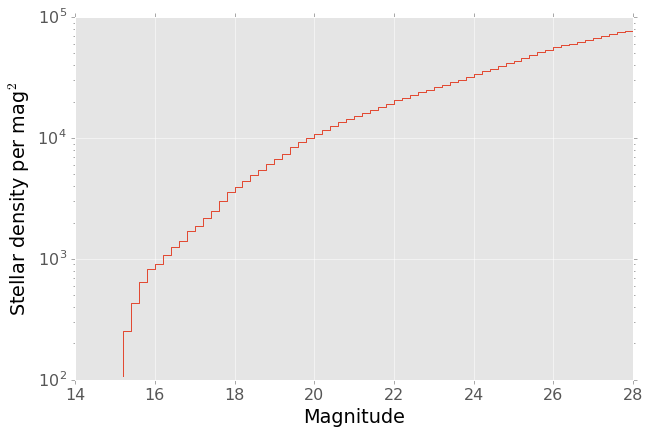

In [93]:

def differential_stellar_density(ra, dec, catsim_data):
    healpix_bin = _raDec2Hpid(64, np.radians(ra), np.radians(dec))
    return catsim_data['bins'], catsim_data['starDensity'][healpix_bin,:]


ret_bins, ret_stars = differential_stellar_density(180, -45, stellar_catsim_data)
plt.plot(ret_bins[1:], ret_stars, drawstyle='steps-pre')
plt.ylabel(r"Stellar density per mag$^2$")
plt.xlabel("Magnitude")
plt.gca().set_yscale('log')

In [169]:
def fp_rate(sigma, shift, threshold):
    lower_half = 0.5 + 0.5*erf(( -threshold*sigma - shift)/(sigma*np.sqrt(2)))    
    upper_half = 1/2.0  - 0.5*erf((threshold*sigma - shift)/(sigma*np.sqrt(2)))
    return lower_half + upper_half

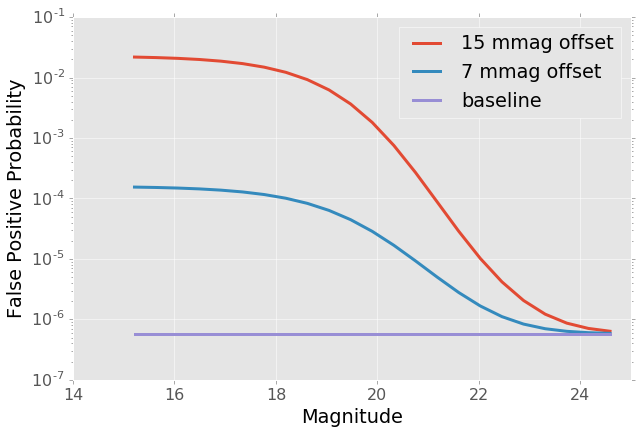

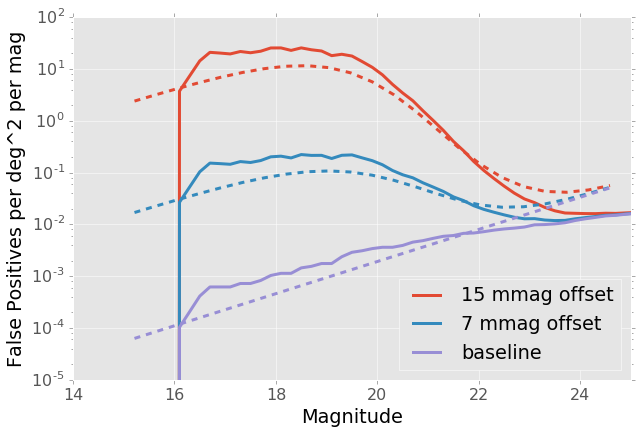

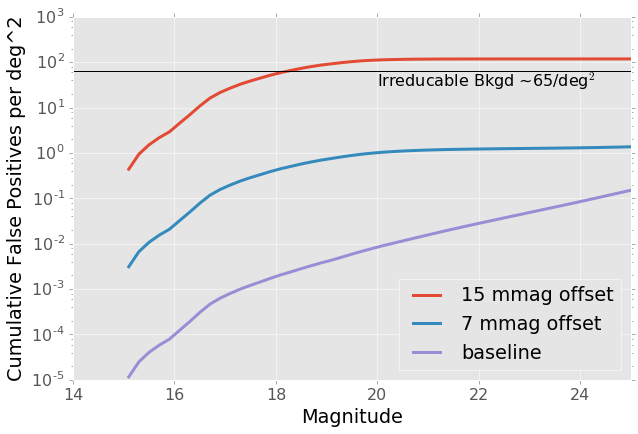

In [175]:
gamma = 0.038
m5 = 24.8
mag_bins = np.linspace(15, 24.8, 24)
mags = 0.5*(mag_bins[1:] + mag_bins[:-1])

coord = SkyCoord(180, -45, frame="galactic", unit="deg")

stellar_mag_bins = stellar_catsim_data['bins']
stellar_mags = 0.5*(stellar_mag_bins[1:] + stellar_mag_bins[:-1])

def phot_uncertainty(mags, m5, gamma):
    # This comes from the overview paper
    x = 10**(0.4*(mags - m5))
    phot_uncertainty = np.sqrt((0.04 - gamma)*x + gamma*x**2 + 0.005**2)
    return phot_uncertainty
    
def galaxy_differential_counts(mag_bins):
    """Differential galaxy counts per square degree"""
    # Cumulative is N_gal = 46 * 10**(0.31*(i-25)) per arcmin square
    differential = 46 * (10**(0.31*(mag_bins[1:] - 25)))
    differential -= 46 * (10**(0.31*(mag_bins[:-1] - 25)))
    return differential*(60**2)
    

trial_offsets = (
    (0.015, "15 mmag offset"),
    (0.007, "7 mmag offset"),
    (0.0, "baseline"))

for offset, label_text in trial_offsets:
    plt.plot(mags, fp_rate(phot_uncertainty(mags, m5, gamma), offset, 5.0), lw=3, label=label_text)

plt.legend(loc=0)
plt.gca().set_yscale('log')
plt.ylabel("False Positive Probability")
plt.xlabel("Magnitude")
plt.xlim(14, 25)

plt.show()
delta_mag = mag_bins[1] - mag_bins[0]
for offset, label_text in trial_offsets:
    galaxy_fp_rates = fp_rate(phot_uncertainty(mags, m5, gamma), offset, 5.0)
    lines = plt.plot(mags, galaxy_differential_counts(mag_bins)*galaxy_fp_rates/delta_mag,
            lw=3, ls='--')

    # The galaxies and stars cases differ only due to different binning
    stellar_fp_rates = fp_rate(phot_uncertainty(stellar_mags, m5, gamma), offset, 5.0)
    delta_stellar_mag = stellar_mags[1] - stellar_mags[0]

    _, stellar_density = differential_stellar_density(coord.icrs.ra.deg, coord.icrs.dec.deg, stellar_catsim_data)
    plt.plot(stellar_mags, stellar_density*stellar_fp_rates/delta_stellar_mag,
             label=label_text,
             ls='-', color=lines[0].get_color(), lw=3)

    
plt.gca().set_yscale('log')
plt.ylabel("False Positives per deg^2 per mag")
plt.xlabel("Magnitude")
plt.xlim(14, 25)

plt.legend(loc=0)

plt.show()
delta_mag = mag_bins[1] - mag_bins[0]
for offset, label_text in trial_offsets:
    
    galaxy_fp_rates = fp_rate(phot_uncertainty(stellar_mags, m5, gamma), offset, 5.0)
    cumulative_galaxies = np.cumsum(galaxy_differential_counts(stellar_mag_bins)*galaxy_fp_rates)
    
    stellar_fp_rates = fp_rate(phot_uncertainty(stellar_mags, m5, gamma), offset, 5.0)
    _, stellar_density = differential_stellar_density(coord.icrs.ra.deg, coord.icrs.dec.deg, stellar_catsim_data)
    cumulative_stars = np.cumsum(stellar_density*stellar_fp_rates)

    lines = plt.plot(stellar_mags, cumulative_galaxies + cumulative_stars,
                     label=label_text, lw=3)

plt.axhline(65.0, color='k')
plt.text(20, 65, r"Irreducable Bkgd ~65/deg$^2$", verticalalignment="top")
plt.gca().set_yscale('log')
plt.ylabel("Cumulative False Positives per deg^2")
plt.xlabel("Magnitude")
plt.xlim(14, 25)
plt.legend(loc=0)

#plt.axhline(0.5*1.7e6)

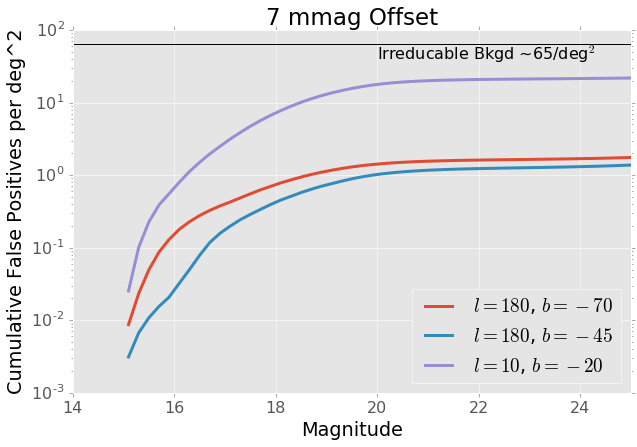

In [176]:

coords = [SkyCoord(180, -70, frame="galactic", unit="deg"),
          SkyCoord(180, -45, frame="galactic", unit="deg"),
          SkyCoord(10, -20, frame="galactic", unit="deg"),
         ]

offset = 0.007

for coord in coords:

    galaxy_fp_rates = fp_rate(phot_uncertainty(stellar_mags, m5, gamma), offset, 5.0)
    cumulative_galaxies = np.cumsum(galaxy_differential_counts(stellar_mag_bins)*galaxy_fp_rates)
    
    stellar_fp_rates = fp_rate(phot_uncertainty(stellar_mags, m5, gamma), offset, 5.0)
    _, stellar_density = differential_stellar_density(coord.icrs.ra.deg, coord.icrs.dec.deg, stellar_catsim_data)
    cumulative_stars = np.cumsum(stellar_density*stellar_fp_rates)

    lines = plt.plot(stellar_mags, cumulative_galaxies + cumulative_stars,
                     lw=3, label="$l={:.0f}$, $b={:.0f}$".format(coord.l.deg, coord.b.deg))
                    
plt.axhline(65.0, color='k')
plt.text(20, 65, r"Irreducable Bkgd ~65/deg$^2$", verticalalignment="top")
plt.gca().set_yscale('log')
plt.ylabel("Cumulative False Positives per deg^2")
plt.xlabel("Magnitude")
plt.xlim(14, 25)
plt.legend(loc=0)
plt.title("{:.0f} mmag Offset".format(offset*1000))

In [172]:

final_fp_counts = []
offsets = 0.001*np.linspace(0.0, 30, 20)
coord = SkyCoord(180, -40, frame="galactic", unit="deg")
sel, = np.where(stellar_mag_bins < 24.8)

for offset in offsets:

    galaxy_fp_rates = fp_rate_test(phot_uncertainty(stellar_mags, m5, gamma), offset, 5.0)
    galaxy_contam = galaxy_differential_counts(stellar_mag_bins)*galaxy_fp_rates
    
    stellar_fp_rates = fp_rate_test(phot_uncertainty(stellar_mags, m5, gamma), offset, 5.0)
    _, stellar_density = differential_stellar_density(coord.icrs.ra.deg, coord.icrs.dec.deg, stellar_catsim_data)
    stellar_contam = stellar_density*stellar_fp_rates
    
    final_fp_counts.append(np.sum(stellar_contam[sel]) + np.sum(galaxy_contam[sel]))


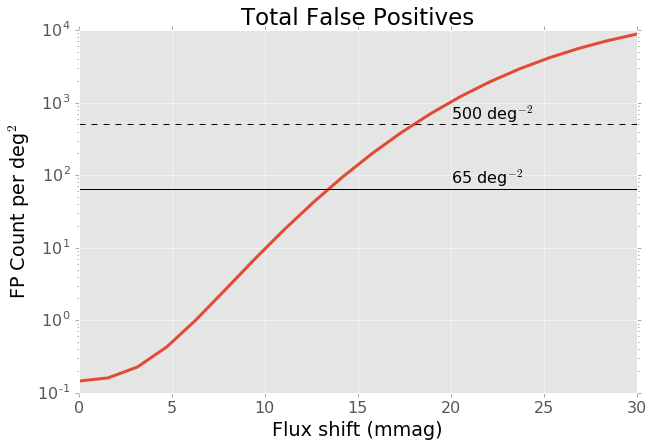

In [173]:
plt.plot(offsets*1000, final_fp_counts, '-', lw=3)
plt.axhline(65.0, color='k')
plt.text(20, 65, "65 deg$^{-2}$", verticalalignment="bottom")
plt.axhline(500.0, color='k', ls='--')
plt.text(20, 500, "500 deg$^{-2}$", verticalalignment="bottom")

plt.xlabel("Flux shift (mmag)")
plt.ylabel("FP Count per deg$^2$")
plt.gca().set_yscale('log')
plt.title("Total False Positives")